# Module

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm.callback import log_evaluation

# Data

In [2]:
data_path = "./data/"

all_data = joblib.load(data_path + 'all_data.joblib')
sub = pd.read_csv(data_path + 'sample_submission.csv')

# Model

## prepare

In [3]:
x_train = all_data[all_data['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis=1)

x_val = all_data[all_data['date_block_num'] == 33]
x_val = x_val.drop(['item_cnt_month'], axis=1)

x_test = all_data[all_data['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis=1)

y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
y_val = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

x_all = pd.concat([x_train, x_val])
y_all = pd.concat([y_train, y_val])

In [4]:
del all_data

## train

- `03_Emprovements.ipynb`에서 찾은 하이퍼 파라미터를 활용

In [5]:
best_params = {
    'num_leaves': 171,
    'learning_rate': 0.01666589592166009,
    'feature_fraction': 0.9565136957103231,
    'bagging_fraction': 0.6500575023723183,
    'bagging_freq': 3,
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1
}

best_iter = 1329

In [7]:
cat_features = ['shop_id', 'type', 'subtype', 'item_category_id', 'city', 'month']

dtrain_all = lgb.Dataset(x_all, y_all, categorical_feature=cat_features)
final_iter = int(best_iter * 1.1)

In [8]:
%%time

final_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain_all,
    num_boost_round=final_iter,
    valid_sets=[dtrain_all],
    callbacks=[
        log_evaluation(period=100)
    ]
)

[100]	training's rmse: 0.880571
[200]	training's rmse: 0.832325
[300]	training's rmse: 0.813599
[400]	training's rmse: 0.802424
[500]	training's rmse: 0.793731
[600]	training's rmse: 0.787014
[700]	training's rmse: 0.780311
[800]	training's rmse: 0.775043
[900]	training's rmse: 0.769645
[1000]	training's rmse: 0.765188
[1100]	training's rmse: 0.761504
[1200]	training's rmse: 0.758161
[1300]	training's rmse: 0.754018
[1400]	training's rmse: 0.75011
CPU times: user 51min 57s, sys: 14.2 s, total: 52min 11s
Wall time: 15min 7s


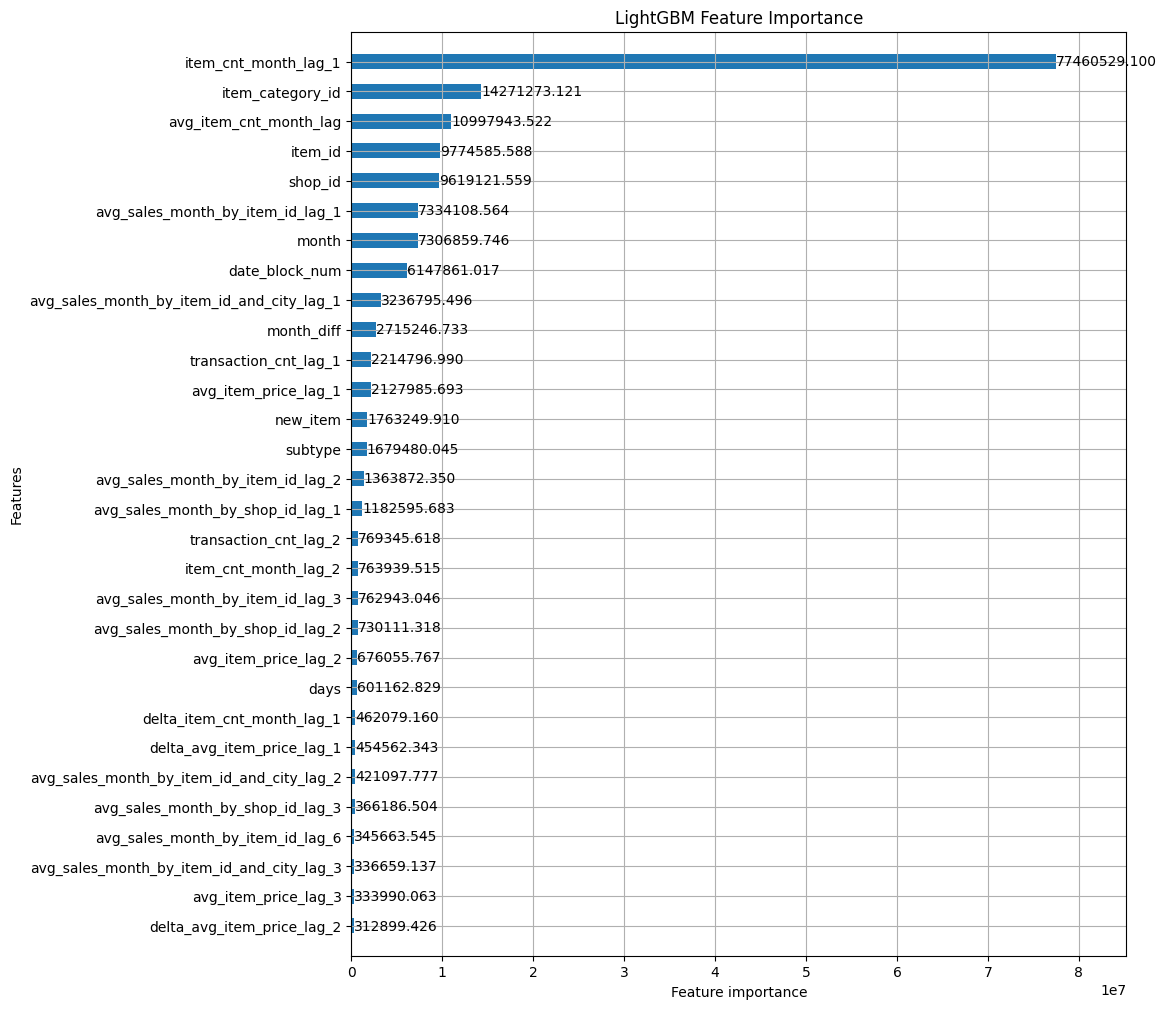

In [9]:
plt.figure(figsize=(10, 12)) 
lgb.plot_importance(final_lgbm_model, max_num_features=30, height=0.5, ax=plt.gca(), importance_type='gain')
plt.title('LightGBM Feature Importance')
plt.show()

- lag_period를 [1,2,3,6,12]로 설정해 분기, 반기, 연단위 관계성을 살폈으나 장기 시차 변수들의 중요도가 떨어짐
- `item_cnt_month_lag_1`의 중요도가 가장 높게 나타남. 타겟값한 가장 근접한 시차 변수의 중요도가 높은 것은 당연하지만, 이에 대한 의존도가 지나치게 높고 여전히 id 변수들의 중요도가 높음

In [10]:
final_lgbm_model.save_model(data_path + '05_3_lgbm_model.txt')

## prediction

In [11]:
predictions = final_lgbm_model.predict(x_test, num_iteration=final_lgbm_model.best_iteration).clip(0, 20)
sub['item_cnt_month'] = predictions
sub.head()

,ID,item_cnt_month
0,0,0.403473
1,1,0.396578
2,2,0.739938
3,3,0.362265
4,4,2.312665


In [12]:
sub.to_csv(data_path + '05_3_submission_lgbm.csv', index=False)

In [13]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/05_3_submission_lgbm.csv" -m "05_3_submission_lgbm2"

100%|██████████████████████████████████████| 5.26M/5.26M [00:00<00:00, 11.5MB/s]
Successfully submitted to Predict Future Sales

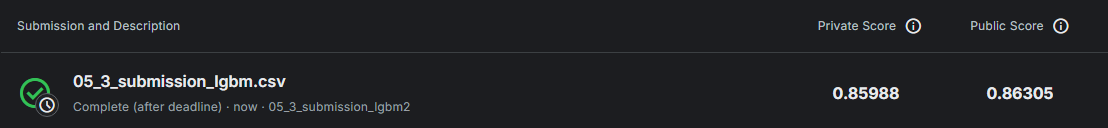

- Private Score 기준 1198 / 16993 (상위 7%)